In [1]:
import cv2
import numpy as np
import os
import sys
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from PIL import Image
import nibabel as nib
import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    
def create_paths(datapath):
    #     Create paths to all nested images
    imagepaths = []
    for root, dirs, files in os.walk(datapath, topdown=False):
        for name in files:
            imagepaths.append(os.path.join(root, name))
    return imagepaths

def get_label(imagepath, csvpath):
    #     Get the diagnosis label for path
    table = pd.read_csv(csvpath)
    idpath = imagepath.split('/')[13]
    img_id = idpath[idpath.find('_I') + 2:-4]
    group = table.loc[table['Image Data ID'] == int(
        img_id)]["Group"].reset_index(drop=True)[0]
    group_to_label = {'CN': 0, 'MCI': 2, 'AD': 1}
    label = group_to_label[group]
    return label

class ADNI(Dataset):
    def __init__(self, datapath, csvpath, labels = [0, 1, 2], transform=None):
        """
        Args:
            datapath (string): Directory with all the images.
            csvpath (string): Path to CSV
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        all_imagepaths = create_paths(datapath)[:-1]
        self.csvpath = csvpath
        self.imagepaths = [path for path in tqdm(all_imagepaths) if get_label(path, csvpath) in labels] 
        self.transform = transform

    def __len__(self):
        #         Returns the length of the dataset
        return len(self.imagepaths)

    def __getitem__(self, idx):
        #         Returns a tuple of the image and its group/label
        imgsize = 64

        if torch.is_tensor(idx):
            idx = idx.tolist()
        imagepath = self.imagepaths[idx]
        label = get_label(imagepath, csvpath)
    

        imgdata = nib.load(imagepath).get_fdata()
        #         temporary, for only one slice
        imgdata = torch.from_numpy(cv2.resize(imgdata[imgdata.shape[0]//2, :, :], (imgsize, imgsize)))

    
        imgdata = torch.stack([imgdata, imgdata, imgdata],0) 
        imgdata = imgdata.reshape(3, imgsize, imgsize)
        
        if self.transform:
            imgdata = self.transform(imgdata)
        
        sample = (imgdata, torch.tensor(label))
        
        return sample
    
    
datapath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T"
csvpath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T_7_08_2020.csv"
dataset = ADNI(datapath, csvpath, labels = [0,1])

lengths = [
    int(len(dataset) * 0.8),
    int(len(dataset) * 0.1),
    int(len(dataset) * 0.1) + 1
]




In [2]:
extraAD = torch.load('../../datasets/GAN_noSS/64ADgan1noSS.pt')
extraNC = torch.load('../../datasets/GAN_noSS/64NCgan1noSS.pt')
dataset = torch.load('../../datasets/64datasetsingle.pt')

dataset = torch.utils.data.ConcatDataset((dataset, extraAD, extraNC))

lengths = [

    int(len(dataset) * 0.8),
    int(len(dataset) * 0.1),
    int(len(dataset) * 0.1) + 1
]



trainset, valset, testset = random_split(dataset, lengths)



image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']} 



In [3]:
import seaborn as sns
sns.set(font_scale=1.4)
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import copy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

    
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25, batch_size = 32):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 100)


        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in tqdm(dataloaders[phase], total = dataset_sizes[phase]//batch_size + 1):
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device)
            
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

              
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_accuracy.append(epoch_acc)

            if phase == 'val':
                val_loss.append(epoch_loss)
                val_accuracy.append(epoch_acc)
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    sns.set(font_scale = 1.4)
    plt.figure(figsize=(10,5))
    plt.title("Train and Val Loss")
    plt.plot(train_loss,label="Train")
    plt.plot(val_loss,label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    plt.figure(figsize=(10,5))
    plt.title("Train and Val Accuracy")
    plt.plot(train_accuracy,label="Train")
    plt.plot(val_accuracy,label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
    model.load_state_dict(best_model_wts)
    return model


Epoch 0/24
----------------------------------------------------------------------------------------------------



train Loss: 0.7259 Acc: 0.5839



val Loss: 0.7810 Acc: 0.6144
Epoch 1/24
----------------------------------------------------------------------------------------------------



train Loss: 0.6658 Acc: 0.6374



val Loss: 0.6084 Acc: 0.7203
Epoch 2/24
----------------------------------------------------------------------------------------------------



train Loss: 0.6054 Acc: 0.6781



val Loss: 0.8772 Acc: 0.6610
Epoch 3/24
----------------------------------------------------------------------------------------------------



train Loss: 0.3390 Acc: 0.8671



val Loss: 2.0362 Acc: 0.5805
Epoch 4/24
----------------------------------------------------------------------------------------------------



train Loss: 0.2368 Acc: 0.9026



val Loss: 0.8431 Acc: 0.7161
Epoch 5/24
----------------------------------------------------------------------------------------------------



train Loss: 0.1929 Acc: 0.9264



val Loss: 2.8327 Acc: 0.7203
Epoch 6/24
----------------------------------------------------------------------------------------------------



train Loss: 0.1528 Acc: 0.9566



val Loss: 7.3614 Acc: 0.5508
Epoch 7/24
----------------------------------------------------------------------------------------------------



train Loss: 0.1072 Acc: 0.9629



val Loss: 3.8367 Acc: 0.7161
Epoch 8/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0868 Acc: 0.9762



val Loss: 3.6630 Acc: 0.7203
Epoch 9/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0653 Acc: 0.9831



val Loss: 2.8255 Acc: 0.5763
Epoch 10/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0822 Acc: 0.9846



val Loss: 5.7056 Acc: 0.5890
Epoch 11/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0588 Acc: 0.9894



val Loss: 5.9062 Acc: 0.5890
Epoch 12/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0571 Acc: 0.9862



val Loss: 4.8622 Acc: 0.5932
Epoch 13/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0500 Acc: 0.9878



val Loss: 2.0122 Acc: 0.5890
Epoch 14/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0320 Acc: 0.9963



val Loss: 5.2622 Acc: 0.5805
Epoch 15/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0609 Acc: 0.9878



val Loss: 5.1810 Acc: 0.5890
Epoch 16/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0464 Acc: 0.9921



val Loss: 2.6273 Acc: 0.5932
Epoch 17/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0397 Acc: 0.9921



val Loss: 3.6725 Acc: 0.7246
Epoch 18/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0309 Acc: 0.9947



val Loss: 4.8028 Acc: 0.7203
Epoch 19/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0451 Acc: 0.9873



val Loss: 4.6520 Acc: 0.5805
Epoch 20/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0450 Acc: 0.9942



val Loss: 1.6323 Acc: 0.5932
Epoch 21/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0397 Acc: 0.9915



val Loss: 0.3390 Acc: 0.8686
Epoch 22/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0392 Acc: 0.9915



val Loss: 5.1264 Acc: 0.5763
Epoch 23/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0391 Acc: 0.9905



val Loss: 0.5060 Acc: 0.7924
Epoch 24/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0358 Acc: 0.9958



val Loss: 5.1893 Acc: 0.5720
Training complete in 1m 14s
Best val Acc: 0.868644


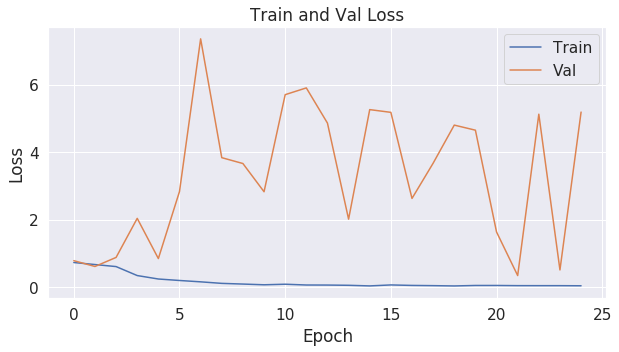

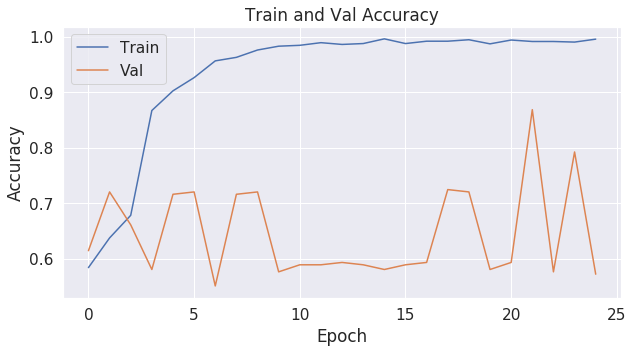

In [4]:
model = models.resnet50(pretrained=True).to(device) 
model.fc = nn.Linear(model.fc.in_features, 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model = train_model(model,  criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes,
                       num_epochs=25)

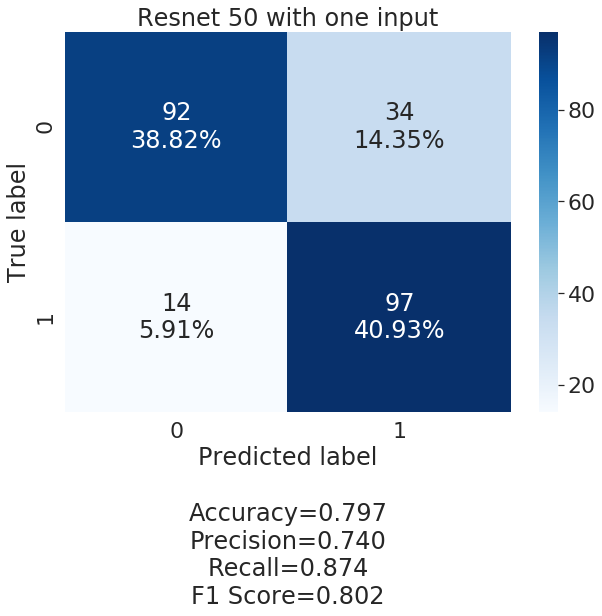

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
from confusionmatrix import make_confusion_matrix


nb_classes = 2
cf = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        classes = classes.to(device)
        inputs = inputs.to(device, dtype=torch.float)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for t, p in zip(classes.view(-1), preds.view(-1)):
            cf[t.long(), p.long()] += 1

cf = np.array(cf)

group_names = ['bruh','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf.reshape(-1)/cf.sum()]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

make_confusion_matrix(cf, group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize= (10,7),
                          cmap='Blues',
                          title='Resnet 50 with one input')

In [6]:
running_loss = 0.0
running_corrects = 0
for inputs, labels in tqdm(dataloaders['test'], total = dataset_sizes['test']//32+1):
    inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device)


    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)


    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    
print(f"Test Loss: {running_loss / dataset_sizes['test']}\nTest Accuracy: {running_corrects.double() / dataset_sizes['test']}")



Test Loss: 0.5735293696575527
Test Accuracy: 0.7974683544303797
